# Практическая работа №2

**UPD:**
Бонусная работа к пр2 будет зачтена вместо любой работы на выбор

## Введение

Самый простой способ использовать "Materials API" для "Materials project" использовать высокоуровневый интерфейс библиотеки [pymatgen](https://pymatgen.org/pymatgen.core.structure.html).

The `https://www.materialsproject.org/rest/v2/query` API предоставляет функциональные возможности для гибких запросов к базе данных материалов проекта с использованием [синтаксиса MongoDB](http://docs.mongodb.org/v2.6/reference/operator/query/) для реализации запросов, которые невозможны с использованием других более простых форм [REST](https://ru.wikipedia.org/wiki/REST). Например, POST для запроса с параметрами.

*Продолжительность* 25 мин.

**Задача:**
- Необходимо найти наиболее перспективные из обозначенных материалов согласно индивидуальному варианту.

In [1]:
import pandas as pd
import numpy as np
from itertools import product, combinations, permutations, combinations_with_replacement
import json
import requests

In [9]:
vars = pd.read_csv('Tasks.csv').reset_index()
vars.columns = ['Вариант', 'Ф.И.', 'X-элемент', 'Свойство', 'Др2']
vars['Вариант'] = vars['Вариант']+1
vars.set_index(['Вариант'])

,Ф.И.,X-элемент,Свойство,Др2
Вариант,,,,
1,Бадамшин Р.,Co,Стабильные,Пластичные
2,Баркина В.,Co,Магнитные,Твердые
3,Вампилова Э.,Ni,Стабильные,Пластичные
4,Волик Я.,Ni,Немагнитные,Твердые
5,Георгиев Р.,Cu,Стабильные,Пластичные
6,Герасименко А.,Cu,Немагнитные,Твердые
7,Голенков А.,Ru,Стабильные,Пластичные
8,Грицких М.,Ru,Немагнитные,Твердые
9,Добратулин К.,Rh,Стабильные,Пластичные


In [ ]:
# key generated from dashboard via web interface of MaterialsProject
x_api_key = input() # was updated
header = {'X-API-KEY':x_api_key}

Рассмотрим эмпирическое правило, позволяющее узнать все химические формулы фаз Гейслера.


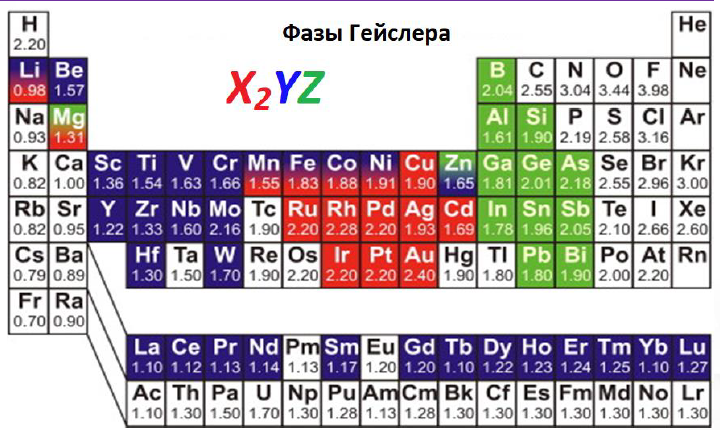

https://www.sciencedirect.com/science/article/abs/pii/S0079678611000021?via%3Dihub

- Все фазы
- По вариантам

In [8]:
# get regex
# Long range data (few hours downlading in sync mode)
# X = ['Fe', 'Co', 'Ni','Cu','Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Ir', 'Pt', 'Au2'] # last for join
# regex = '2|'.join(X)
regex = 'Pt2'

Y = ['Li', 'Be', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Hf', 'W']
Z = ['Mg', 'Zn', 'B', 'Al', 'Si', 'Ga', 'Ge', 'As', 'In', 'Sn', 'Sb', 'Pb', 'Bi']

elements = Y + Z
regex

'Pt2'

- **Магнитные:** полный магнитный момент > 0.1 $\mu B$ // **Немагнитные:** полный магнитный момент < 0.1 $\mu B$
- **Проводники:** ширина запрещенной зоны = 0 // **Диэлектрики:** ширина запрещенной зоны > 2.5 eV
- **Пластичные:** критерий Пуха + давление Коши
- **Стабильные:** расстояние до "convex hull"


Синтаксис сравнения в MongoDB:
- `$gt` - greater than
- `$lt` - less than
- `$eq` - equal

**В приведенном ниже запросе нет проверки того, что Y и Z элементы на своих местах.*

In [9]:
data = {
    'criteria': {
        'elements': {'$in':elements},       # elements that should be on formula
        'pretty_formula': {'$regex':regex},
        'elasticity':{'$exists':'true'},
        'nelements': 3,
        'spacegroup.symbol':'Fm-3m',         # Only structures appropriate to Heusler phases
        
        # Features for variants
        'total_magnetization':{'$lt':0.1}, # MAGNETIC PROPERTIES
#         'band_gap': {'$eq': 0.0},            # CONDUCTIVE PROPERTIES
#         'e_above_hull':{'$eq':0.0},          # STABILITY
    },
    'properties': [
        'pretty_formula',           # STOICHIOMETRIC FORMULA
        'material_id',
        'elasticity.G_VRH',         # Shear moduli
        'elasticity.K_VRH',         # Bulk moduli
        'elasticity.elastic_tensor', # Tensor
        'cif', # structure
    ]
}

r = requests.post('https://materialsproject.org/rest/v2/query',
                 headers=header,
                 data={k: json.dumps(v) for k,v in data.items()})

response_content = r.json() # a dict
print(f"Total samples found: {response_content['num_results']}")

Total samples found: 22


In [10]:
df = pd.DataFrame.from_dict(response_content['response'])
df

,pretty_formula,material_id,elasticity.G_VRH,elasticity.K_VRH,elasticity.elastic_tensor,cif
0,LiHfPt2,mp-867834,18.0,143.0,"[[149.0, 140.0, 140.0, 0.0, 0.0, 0.0], [140.0,...",# generated using pymatgen\ndata_LiHfPt2\n_sym...
1,LiZrPt2,mp-865866,17.0,140.0,"[[147.0, 136.0, 136.0, 0.0, 0.0, 0.0], [136.0,...",# generated using pymatgen\ndata_LiZrPt2\n_sym...
2,ScSnPt2,mp-30844,14.0,139.0,"[[138.0, 140.0, 140.0, 0.0, 0.0, 0.0], [140.0,...",# generated using pymatgen\ndata_ScSnPt2\n_sym...
3,LiLuPt2,mp-861652,67.0,109.0,"[[62.0, 132.0, 132.0, 0.0, 0.0, 0.0], [132.0, ...",# generated using pymatgen\ndata_LiLuPt2\n_sym...
4,HfZnPt2,mp-983430,32.0,212.0,"[[222.0, 207.0, 207.0, 0.0, 0.0, 0.0], [207.0,...",# generated using pymatgen\ndata_HfZnPt2\n_sym...
5,LiScPt2,mp-865228,73.0,114.0,"[[-1.0, 171.0, 171.0, 0.0, 0.0, 0.0], [171.0, ...",# generated using pymatgen\ndata_LiScPt2\n_sym...
6,YCdPt2,mp-865524,19.0,114.0,"[[120.0, 112.0, 112.0, 0.0, 0.0, 0.0], [112.0,...",# generated using pymatgen\ndata_YCdPt2\n_symm...
7,LiAlPt2,mp-862296,134.0,161.0,"[[-13.0, 249.0, 249.0, 0.0, 0.0, 0.0], [249.0,...",# generated using pymatgen\ndata_LiAlPt2\n_sym...
8,TiZnPt2,mp-861619,-67.0,180.0,"[[142.0, 199.0, 199.0, 0.0, 0.0, 0.0], [199.0,...",# generated using pymatgen\ndata_TiZnPt2\n_sym...
9,ScGaPt2,mp-867923,-112.0,148.0,"[[123.0, 161.0, 161.0, 0.0, 0.0, 0.0], [161.0,...",# generated using pymatgen\ndata_ScGaPt2\n_sym...


## Упругость материалов

Упругость материала описывается тензором упругих констант второго порядка, которые по-сути являются производными энергии по деформации, и фактически характеризуют скорость изменения внутренней энергии тела в зависимости от приложенных напряжений. 

Тензор упругости представляет собой тензор четвертого ранга с элементами $C_{ijkl}$, который для кристаллических тел, в силу симметричности кристаллической решетки становится симметричным и по [соглашению Эйнштейна](https://ru.wikipedia.org/wiki/Соглашение_Эйнштейна) может быть сведён тензору второго порядка:

$$
\begin{bmatrix}
  c_{11}& c_{12}& c_{13}& 0& 0& 0\\
  c_{21}& c_{22}& c_{23}& 0& 0& 0\\
  c_{31}& c_{32}& c_{33}& 0& 0& 0\\
  0& 0& 0& c_{44}& 0& 0\\
  0& 0& 0& 0& c_{55}& 0\\
  0& 0& 0& 0& 0& c_{66}
\end{bmatrix}
$$

Следовательно, любые деформации этого материала будут приводить к напряжениям, которые можно выразить в [тензорной форме](https://ru.wikipedia.org/wiki/Тензор_напряжений) произведением [тензора упругости](https://ru.wikipedia.org/wiki/Нотация_Фойгта#:~:text=Нотация%20Фойгта%20—%20матричная%20форма,закона%20Гука%20для%20анизотропных%20материалов) на [тензор относительной деформации](https://ru.wikipedia.org/wiki/Тензор_деформации):

$${\displaystyle {\begin{pmatrix}\sigma_{1}\\\sigma_{2}\\\sigma_{3}\\\sigma_{4}\\\sigma_{5}\\\sigma_{6}\end{pmatrix}}={\begin{pmatrix}c_{11}&c_{12}&c_{13}&0&0&0\\c_{21}&c_{22}&c_{23}&0&0&0\\ c_{31}&c_{32}&c_{33}&0&0&0\\0&0&0&c_{44}&0&0\\0&0&0&0 &c_{55}&0\\0&0&0&0&0&c_{66}\\\end{pmatrix}}{\begin{pmatrix}\varepsilon_{1}\\\varepsilon _{2}\\\varepsilon _{3}\\2\varepsilon _{4}\\2\varepsilon_{5}\\2\varepsilon_{6}\end{pmatrix}}}$$

где 
- $\sigma_i$ – компоненты тензора напряжений,
- $c_{ij}$ – компоненты тензора упругих постоянных, 
- $\varepsilon_i$ – компоненты тензора деформаций.

«Для ковалентных материалов с направленным характером атомных связей, давление Коши оказывается отрицательным ($c_{12} < c_{44}$), т.к. в этом случае сопротивление материала деформации сдвига ($c_{44}$) намного больше, чем сопротивление изменению объема ($c_{12}$). С другой стороны, для металлоподобной связи, где электроны практически делокализованы, давление Коши должно быть положительным ($c_{12} > c_{44}$)». Это объясняется, что пластическая деформация кристаллов, обусловлена также скольжением дислокаций. При этом скольжение в плоскости, вдоль которой располагается дислокация начинается после достижения некоторой величины касательных напряжений, а сопротивление материала сдвиговой деформации кубического кристалла описывается упругими константами $c_{44}$, $c_{55}$ и $c_{66}$, а также модулем сдвига. Все касательные напряжения в случае тензора упругих постоянных второго порядка описываются в тензорной форме, как:

$$\sigma_i=\sum_{i=4}^{6}\sum_{j=4}^{6}c_{ij}\varepsilon_i$$

Следовательно, 

Сопротивление материала изменению длины связей описываются константами $c_{12}$, $c_{13}$, $c_{21}$, $c_{23}$, $c_{31}$, $c_{32}$, которые, в случае симметричного тензора упругих постоянных второго рода равны [*1*]. То есть при приложении внешней нагрузки, изменения длины связей энергетически более выгодны, если $c_{12}$ < $c_{44}$, а деформация носит более упругий характер. 

Аналогично, если отношение модуля сдвига к модулю объемной упругости превышает 0,5. Это объясняет близкий физический смысл, соотношений упругих констант, согласно определениям критерия Пуха [[Pugh1931](https://doi.org/10.1080/14786440808520496)] и давления Коши [[Pettifor1991](https://doi.org/https://doi.org/10.1098/rsta.1991.0024)]. При этом несмотря на то, что работа [[Pugh1931](https://doi.org/10.1080/14786440808520496)] является более ранней, она позволяет учесть поликристаллическое приближение для модулей упругости сформулированное в работе Хилла [[Hill1952](https://doi.org/10.1088/0370-1298/65/5/307)].

*[1] Ландау Л.Д., Лифшиц Е.М. Теоретическая физика. Теория упругости. М.: НАУКА, 1987, 248 стр.*

Расчет значений дескрипторов пластичности:

In [11]:
df['c12'] = df['elasticity.elastic_tensor'].apply(lambda x: x[0][1])
df['c44'] = df['elasticity.elastic_tensor'].apply(lambda x: x[3][3])
df['G/B'] = df['elasticity.G_VRH']/df['elasticity.K_VRH']
df['Pc'] = df.c12 - df.c44

Применение критериев пластичности

In [12]:
df_plastic = df[df.Pc > 0].copy()
df_plastic = df_plastic[df_plastic['G/B'] < 0.5]
df_plastic

,pretty_formula,material_id,elasticity.G_VRH,elasticity.K_VRH,elasticity.elastic_tensor,cif,c12,c44,G/B,Pc
0,LiHfPt2,mp-867834,18.0,143.0,"[[149.0, 140.0, 140.0, 0.0, 0.0, 0.0], [140.0,...",# generated using pymatgen\ndata_LiHfPt2\n_sym...,140.0,41.0,0.125874,99.0
1,LiZrPt2,mp-865866,17.0,140.0,"[[147.0, 136.0, 136.0, 0.0, 0.0, 0.0], [136.0,...",# generated using pymatgen\ndata_LiZrPt2\n_sym...,136.0,36.0,0.121429,100.0
2,ScSnPt2,mp-30844,14.0,139.0,"[[138.0, 140.0, 140.0, 0.0, 0.0, 0.0], [140.0,...",# generated using pymatgen\ndata_ScSnPt2\n_sym...,140.0,50.0,0.100719,90.0
4,HfZnPt2,mp-983430,32.0,212.0,"[[222.0, 207.0, 207.0, 0.0, 0.0, 0.0], [207.0,...",# generated using pymatgen\ndata_HfZnPt2\n_sym...,207.0,74.0,0.150943,133.0
6,YCdPt2,mp-865524,19.0,114.0,"[[120.0, 112.0, 112.0, 0.0, 0.0, 0.0], [112.0,...",# generated using pymatgen\ndata_YCdPt2\n_symm...,112.0,47.0,0.166667,65.0
8,TiZnPt2,mp-861619,-67.0,180.0,"[[142.0, 199.0, 199.0, 0.0, 0.0, 0.0], [199.0,...",# generated using pymatgen\ndata_TiZnPt2\n_sym...,199.0,76.0,-0.372222,123.0
9,ScGaPt2,mp-867923,-112.0,148.0,"[[123.0, 161.0, 161.0, 0.0, 0.0, 0.0], [161.0,...",# generated using pymatgen\ndata_ScGaPt2\n_sym...,161.0,35.0,-0.756757,126.0
10,ScZnPt2,mp-867768,-62.0,142.0,"[[110.0, 158.0, 158.0, 0.0, 0.0, 0.0], [158.0,...",# generated using pymatgen\ndata_ScZnPt2\n_sym...,158.0,60.0,-0.436620,98.0
11,ScAlPt2,mp-973153,28.0,150.0,"[[173.0, 139.0, 139.0, 0.0, 0.0, 0.0], [139.0,...",# generated using pymatgen\ndata_ScAlPt2\n_sym...,139.0,39.0,0.186667,100.0
12,ZrInPt2,mp-571310,18.0,161.0,"[[163.0, 159.0, 159.0, 0.0, 0.0, 0.0], [159.0,...",# generated using pymatgen\ndata_ZrInPt2\n_sym...,159.0,52.0,0.111801,107.0


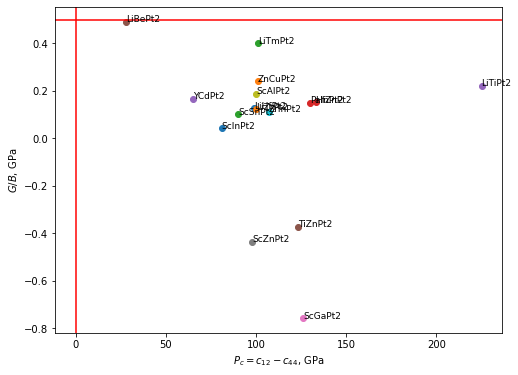

In [13]:
import matplotlib.pyplot as plt

def plot_plasticity(df):
    plt.figure(figsize=(8, 6))
    for idx in df.index:
        data = df.loc[idx]
        text = data['pretty_formula']
        x = data['Pc']
        y = data['G/B']
        plt.plot(x,y,'o')
        plt.annotate(text, (x,y), fontsize=9)

    plt.axvline(x=0.0, color='r', linestyle='-')
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.xlabel('$P_c=c_{12}-c_{44}$, GPa')
    plt.ylabel('$G/B$, GPa')
    plt.show()

plot_plasticity(df_plastic)

Удалим выбросы:

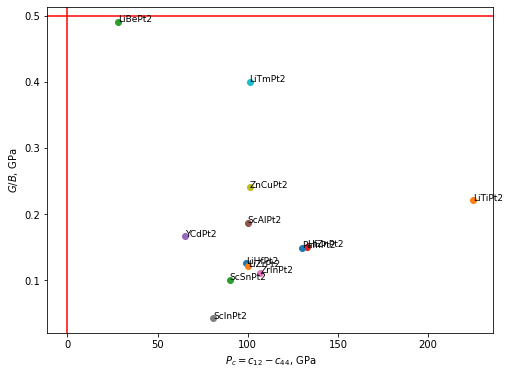

In [14]:
df_plast_clr = df_plastic[df_plastic['G/B'] > 0].copy()
plot_plasticity(df_plast_clr)

**Вопрос:** Как сделать это проще? (как сразу отфильтровать лишнее, ещё на стадии запроса?)

Попробуем сформулировать краткое правило, позволяющее находить наиболее пластичные соединения по комбинации критериев:

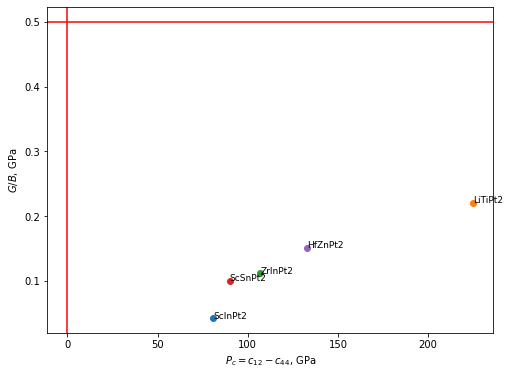

In [15]:
plot_plasticity(df_plast_clr.loc[(df_plast_clr['G/B']/df_plast_clr['Pc']).sort_values().head(5).index])

## Поиск новых структур

In [16]:
#Сохранение в файл запись структуры смоделированной ячейки
cif = df[df['pretty_formula'] == 'LiTiPt2'].cif.values[0]
filename = 'struct.cif'
with open(filename, 'w') as f:
    f.write(cif)

## Содержание отчёта

- Ф.И.
- Вариант
- Количество составов
- Выбранный элемент
- Визуализация структуры
- Строчное описание структуры в формате `POSCAR`

# Домашняя работа №2

**Задача:**
- Составить формулы соединений, которых нет в базе, испльзуя эмпирическое правило составления формул фаз Гейслера
- Это соединения должны быть наиболее близки к самым перспектиным из найденных
- Описать возможную структуру этого соединения!

Задача по вариантам:
- *для поиска пластичных соединений:* Предложите собственный комплексный дескриптор, связывающий два извествных критерия
- *для поиска наиболее твердых соединений:* выполните расчеты твердости по формулам ниже, основываясь также на материалах предыдущих занятий

Одна из множества формул для оценки твердости через упругие свойства:

$$H_v = 2(\frac{9E(1-2\nu)^2}{8(1+\nu)^3})^{0.585}-3$$

- https://doi.org/10.1063/1.5113622


Формула для точного определения [коэффициента Пуассона](https://ru.wikipedia.org/wiki/Коэффициент_Пуассона)
$$\nu = \frac{3K_{VRH} - 2G_{VRH}}{6K_{VRH} + 2G_{VRH}}$$
- [[Описание](https://docs.materialsproject.org/methodology/elasticity/)]

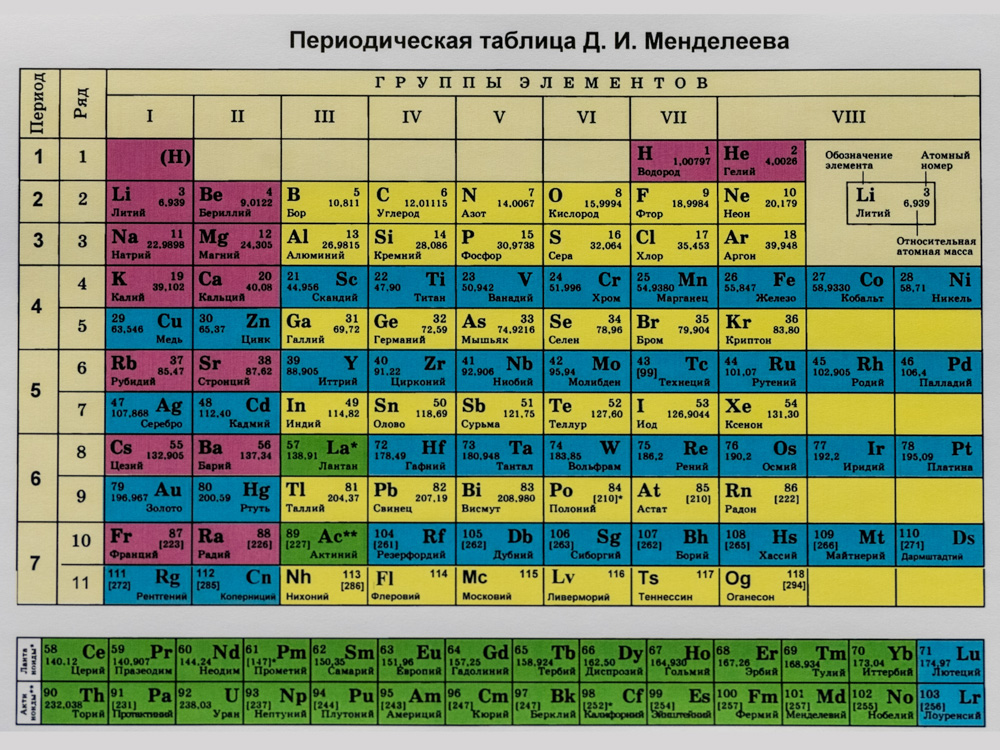